# Ejercicio práctico Series Temporales con Prophet

En este ejercicio utilizaremos los datos de los nuevos casos de COVID-19 rastreados por el New York Times. El código se basa en el el reporitorio del git de github.com/mitkrieg

### Importación de datos y funciones

In [1]:
from fbprophet import Prophet
import pandas as pd
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")
df['new_cases'] = df.cases - df.cases.shift().fillna(0)

### Preparación de los datos

In [3]:
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df['weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)
df.tail()

,cases,deaths,new_cases,weekly_avg
date,,,,
2023-03-19,103784916,1133826,1424.0,35247.571429
2023-03-20,103794703,1133964,9787.0,34772.142857
2023-03-21,103813076,1134177,18373.0,34514.857143
2023-03-22,103864888,1134913,51812.0,22255.285714
2023-03-23,103910034,1135343,45146.0,20924.714286


In [4]:
ts = pd.DataFrame({'ds':df.index,'y':df.new_cases})
ts['cap'] = 30000
ts['floor'] = 0
ts.head()

,ds,y,cap,floor
date,,,,
2020-01-21,2020-01-21,1.0,30000,0
2020-01-22,2020-01-22,0.0,30000,0
2020-01-23,2020-01-23,0.0,30000,0
2020-01-24,2020-01-24,1.0,30000,0
2020-01-25,2020-01-25,1.0,30000,0


### Entrenamiento básico de un modelo

In [5]:
from fbprophet import Prophet

# instantiate the model and fit the timeseries
prophet = Prophet()
prophet.fit(ts)

# create a future data frame 
future = prophet.make_future_dataframe(periods=25)
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
0,2020-01-21,201543.610917,92342.853315,319035.705123
1,2020-01-22,211106.866730,102035.296116,320064.510897
2,2020-01-23,186017.307413,75116.941355,303297.304864
3,2020-01-24,171184.272779,53625.743684,290070.969949
4,2020-01-25,106693.152314,-8385.622564,224631.238981


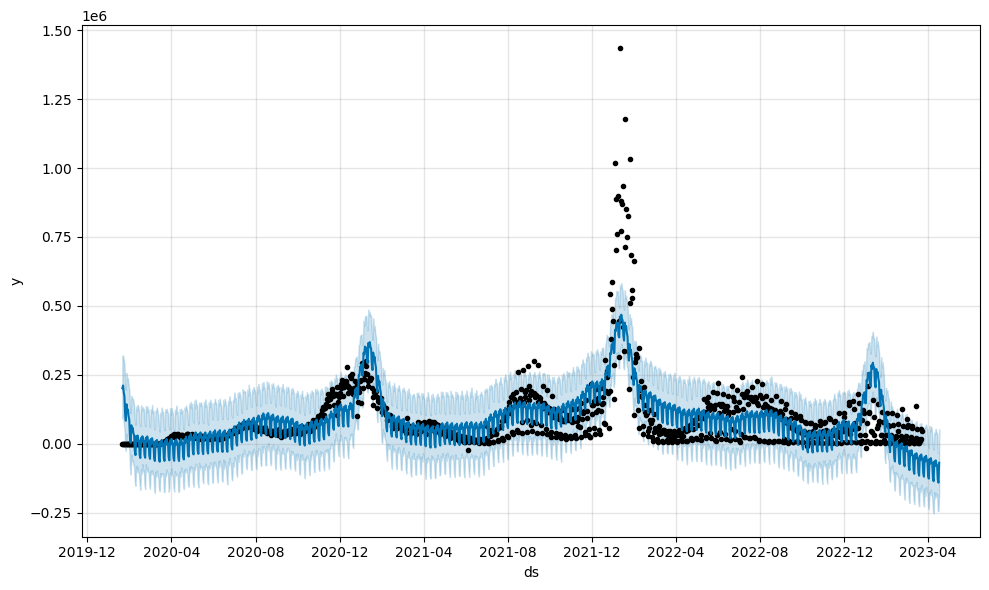

In [6]:
# plot
fig = prophet.plot(forecast)

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


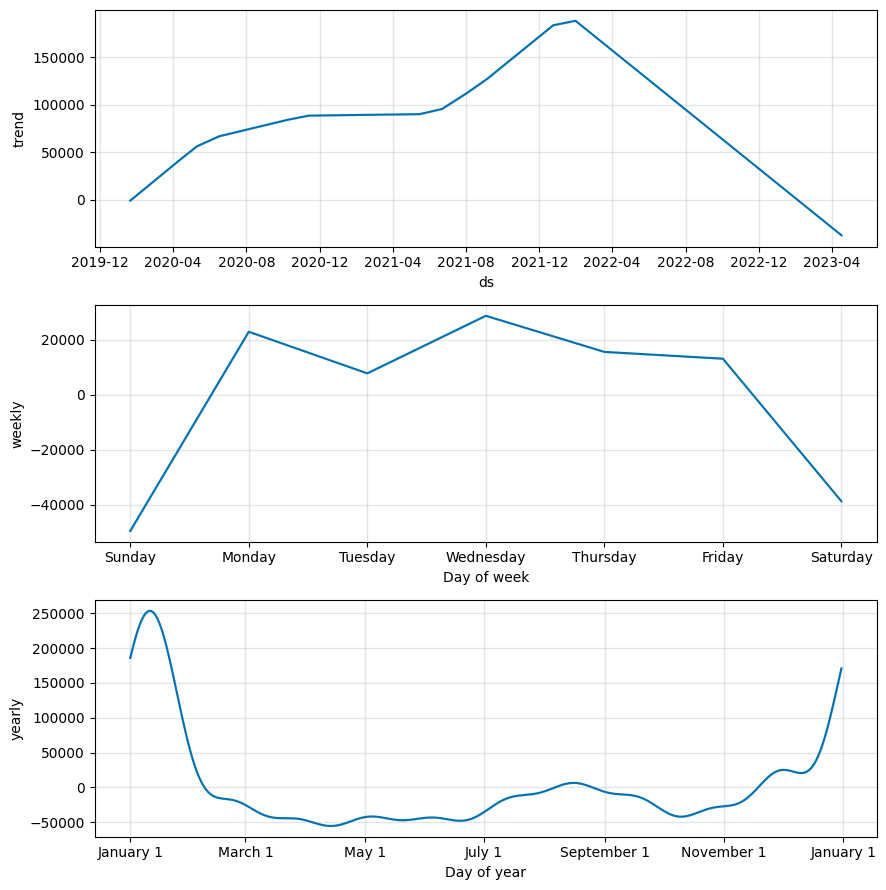

In [7]:
fig = prophet.plot_components(forecast)

In [8]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(prophet, initial='300 days', period = '31 days', horizon = '100 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

INFO:fbprophet:Making 25 forecasts with cutoffs between 2020-11-29 00:00:00 and 2022-12-13 00:00:00


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [47]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,1.059261e+09,32546.290453,27602.373448,0.138530,0.147220,0.3
1,11 days,9.754484e+08,31232.169138,26482.897014,0.133191,0.142300,0.3
2,12 days,1.167512e+09,34168.882004,30180.599622,0.148484,0.160581,0.2
3,13 days,1.303483e+09,36103.775581,32509.272516,0.154177,0.169907,0.2
4,14 days,1.480741e+09,38480.400301,36015.671617,0.168565,0.180091,0.1


In [48]:
df_p.tail(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
86,96 days,6.570824e+10,256336.186780,256133.500456,4.078413,4.225642,0.0
87,97 days,6.642071e+10,257722.147521,257510.747543,4.020784,4.085491,0.0
88,98 days,6.718756e+10,259205.639102,258979.448442,3.993048,3.987863,0.0
89,99 days,6.885553e+10,262403.374502,262188.442691,4.073988,4.086961,0.0
90,100 days,7.074712e+10,265983.301146,265782.470782,4.240344,4.192412,0.0


In [26]:
df_p.mean()

horizon     55 days 00:00:00
mse              1.85321e+10
rmse                  107983
mae                   102711
mape                 1.12723
mdape                 1.0732
coverage            0.226374
dtype: object

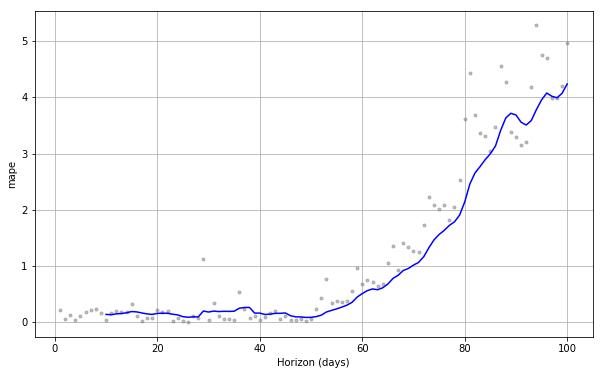

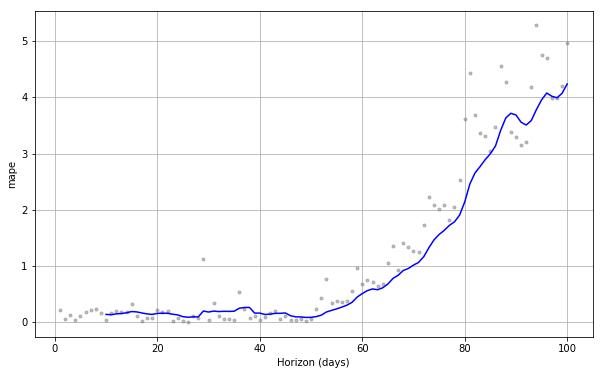

In [25]:
plot_cross_validation_metric(df_cv, metric='mape')

### Optimización del modelo

In [30]:
m = Prophet(weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=1)
m.fit(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
future = m.make_future_dataframe(periods=25)
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-21,-1443.913735,-23494.163689,19653.826927
1,2020-01-22,-1381.412073,-23426.486262,20228.732462
2,2020-01-23,-1318.910411,-22954.650827,21440.094829
3,2020-01-24,-1256.408749,-23205.137751,20478.423651
4,2020-01-25,-1193.907088,-22089.486293,19081.610392
...,...,...,...,...
586,2021-08-29,167615.340364,138043.223308,194038.831251
587,2021-08-30,170539.461236,141671.363540,199338.680132
588,2021-08-31,173463.582108,143550.998745,201623.579804
589,2021-09-01,176387.702980,146774.141427,207483.555602


### Visualizar predicciones

C:\Users\Leyre\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Leyre\anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



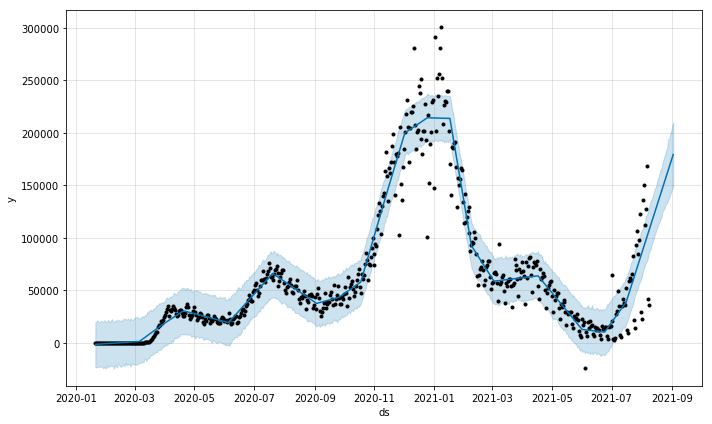

In [49]:
fig = m.plot(forcast)

In [54]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),m,forcast)

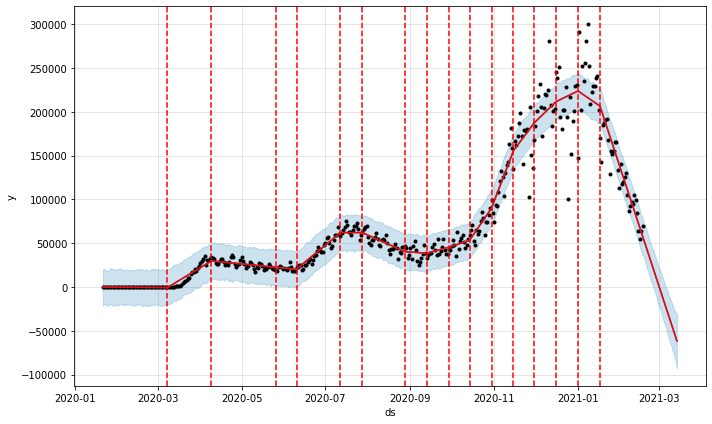

In [55]:
fig

In [32]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forcast)

In [40]:
df_p = performance_metrics(df_cv)
df_p.head(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,1.059261e+09,32546.290453,27602.373448,0.138530,0.147220,0.3
1,11 days,9.754484e+08,31232.169138,26482.897014,0.133191,0.142300,0.3
2,12 days,1.167512e+09,34168.882004,30180.599622,0.148484,0.160581,0.2
3,13 days,1.303483e+09,36103.775581,32509.272516,0.154177,0.169907,0.2
4,14 days,1.480741e+09,38480.400301,36015.671617,0.168565,0.180091,0.1
5,15 days,2.282785e+09,47778.496280,43056.977368,0.189615,0.187969,0.1
6,16 days,2.213156e+09,47044.194422,41859.849277,0.183312,0.187969,0.1
7,17 days,1.984349e+09,44546.027830,37550.372385,0.163938,0.175684,0.2
8,18 days,1.696921e+09,41193.705333,33514.195952,0.147505,0.160581,0.2
9,19 days,1.603894e+09,40048.644065,31622.242931,0.138400,0.133475,0.3


In [42]:
df_p.mean()

horizon     55 days 00:00:00
mse              1.85321e+10
rmse                  107983
mae                   102711
mape                 1.12723
mdape                 1.0732
coverage            0.226374
dtype: object